<a href="https://colab.research.google.com/github/ryasrk/Real-Time-Face-Detection-and-Emotion-Recognition/blob/main/emotion_FER2013_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten, Dense, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Concatenate, Activation,
                                     BatchNormalization, Input, SeparableConv2D, Multiply, Reshape, Add)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

# Define the destination directory
destination = "/content/emotions/fer2013"

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Move the downloaded files
shutil.move(path, destination)

print("Dataset moved to:", destination)

100%|██████████| 60.3M/60.3M [00:00<00:00, 74.0MB/s]

Extracting files...


Dataset moved to: /content/emotions/fer2013


In [ ]:
# Define the dataset directory
dataset_test = "/content/emotions/fer2013/1/test"
dataset_train = "/content/emotions/fer2013/1/train"

# Create an ImageDataGenerator instance
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    shear_range=0.1,
    zoom_range=0.1,
    rotation_range=10,
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=(48, 48),  # Adjust based on your CNN input size
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='categorical',  # Use 'sparse' for integer labels
    subset='training'
)

# Load validation data
val_generator = validation_datagen.flow_from_directory(
    dataset_test,
    target_size=(48, 48),
    batch_size=32,
    color_mode = 'grayscale',
    class_mode='categorical',
    subset='validation'
)

# Print class labels
print("Class labels:", train_generator.class_indices)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
def se_block(input_tensor, reduction=16):
    """Squeeze and Excitation block to recalibrate channel-wise feature responses."""
    channels = int(input_tensor.shape[-1])
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // reduction, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

def residual_se_block(x, filters, kernel_size=3, strides=1, dropout_rate=0.25, use_se=True):
    """Residual block with separable convolutions and optional SE block."""
    shortcut = x

    # First separable convolution
    x = SeparableConv2D(filters, kernel_size, padding='same', strides=strides, activation='relu')(x)
    x = BatchNormalization()(x)

    # Second separable convolution
    x = SeparableConv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Optionally apply squeeze and excitation
    if use_se:
        x = se_block(x, reduction=16)

    # Adjust the shortcut if necessary
    if strides != 1 or int(shortcut.shape[-1]) != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add residual connection and activate
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Downsample spatially and add dropout for regularization
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)
    return x

def create_best_emotion_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    # Initial standard convolution layer to expand channels
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)

    # Residual-SE Block 1: filters=32
    x = residual_se_block(x, filters=32, kernel_size=3, strides=1, dropout_rate=0.25, use_se=True)

    # Residual-SE Block 2: filters=64
    x = residual_se_block(x, filters=64, kernel_size=3, strides=1, dropout_rate=0.25, use_se=True)

    # Residual-SE Block 3: filters=128
    x = residual_se_block(x, filters=128, kernel_size=3, strides=1, dropout_rate=0.25, use_se=True)

    # One more block with increased filters for deeper features
    x = residual_se_block(x, filters=256, kernel_size=3, strides=1, dropout_rate=0.3, use_se=True)

    # Global Average Pooling reduces parameters versus Flattening
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers for final classification
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model instance and display its summary.
model = create_best_emotion_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 48, 48, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 48, 48, 32)     │            320 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_127   │ (None, 48, 48, 32)     │            128 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_72       │ (None, 48, 48, 32)     │          1,344 │ batch_normalization_1… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_128   │ (None, 48, 48, 32)     │            128 │ separable_conv2d_72[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_73       │ (None, 48, 48, 32)     │          1,344 │ batch_normalization_1… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_129   │ (None, 48, 48, 32)     │            128 │ separable_conv2d_73[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_95 (Dense)          │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_96 (Dense)          │ (None, 32)             │             96 │ dense_95[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_36 (Reshape)      │ (None, 1, 1, 32)       │              0 │ dense_96[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_36 (Multiply)    │ (None, 48, 48, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ reshape_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_36 (Add)              │ (None, 48, 48, 32)     │              0 │ multiply_36[0][0],     │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 48, 48, 32)     │              0 │ add_36[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_42     

 Total params: 268,325 (1.02 MB)

 Trainable params: 264,933 (1.01 MB)

 Non-trainable params: 3,392 (13.25 KB)

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Stop when validation loss stops improving
    patience=50,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore best weights
)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    "emotions.h5",  # File name
    monitor='val_accuracy',  # Save the model with the best validation accuracy
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=300,  # Can be higher since early stopping prevents unnecessary training
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping,checkpoint]  # Add callbacks here
)

Epoch 1/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2000 - loss: 2.1393
Epoch 1: val_accuracy improved from -inf to 0.24860, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.2000 - loss: 2.1389 - val_accuracy: 0.2486 - val_loss: 1.8462
Epoch 2/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2746 - loss: 1.8032
Epoch 2: val_accuracy improved from 0.24860 to 0.38617, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.2747 - loss: 1.8030 - val_accuracy: 0.3862 - val_loss: 1.6244
Epoch 3/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3980 - loss: 1.5514
Epoch 3: val_accuracy improved from 0.38617 to 0.45880, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.3980 - loss: 1.5513 - val_accuracy: 0.4588 - val_loss: 1.3916
Epoch 4/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4477 - loss: 1.4293
Epoch 4: val_accuracy improved from 0.45880 to 0.49441, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.4477 - loss: 1.4293 - val_accuracy: 0.4944 - val_loss: 1.3094
Epoch 5/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4710 - loss: 1.3775
Epoch 5: val_accuracy improved from 0.49441 to 0.50908, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4711 - loss: 1.3774 - val_accuracy: 0.5091 - val_loss: 1.3194
Epoch 6/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4961 - loss: 1.3245
Epoch 6: val_accuracy improved from 0.50908 to 0.51746, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4961 - loss: 1.3244 - val_accuracy: 0.5175 - val_loss: 1.3733
Epoch 7/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5141 - loss: 1.2840
Epoch 7: val_accuracy improved from 0.51746 to 0.53352, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5141 - loss: 1.2841 - val_accuracy: 0.5335 - val_loss: 1.2101
Epoch 8/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5267 - loss: 1.2571
Epoch 8: val_accuracy improved from 0.53352 to 0.57612, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5267 - loss: 1.2571 - val_accuracy: 0.5761 - val_loss: 1.1517
Epoch 9/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5311 - loss: 1.2324
Epoch 9: val_accuracy did not improve from 0.57612
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5310 - loss: 1.2324 - val_accuracy: 0.5559 - val_loss: 1.1591
Epoch 10/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5415 - loss: 1.2042
Epoch 10: val_accuracy did not improve from 0.57612
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5415 - loss: 1.2042 - val_accuracy: 0.5691 - val_loss: 1.1368
Epoch 11/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5508 - loss: 1.1917
Epoch 11: val_accuracy improved from 0.57612 to 0.59497, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5508 - loss: 1.1917 - val_accuracy: 0.5950 - val_loss: 1.0941
Epoch 12/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5487 - loss: 1.1850
Epoch 12: val_accuracy improved from 0.59497 to 0.60056, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5487 - loss: 1.1850 - val_accuracy: 0.6006 - val_loss: 1.0985
Epoch 13/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5552 - loss: 1.1771
Epoch 13: val_accuracy did not improve from 0.60056
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5552 - loss: 1.1771 - val_accuracy: 0.5901 - val_loss: 1.0967
Epoch 14/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5633 - loss: 1.1579
Epoch 14: val_accuracy improved from 0.60056 to 0.60684, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5633 - loss: 1.1579 - val_accuracy: 0.6068 - val_loss: 1.0499
Epoch 15/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5687 - loss: 1.1498
Epoch 15: val_accuracy did not improve from 0.60684
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5687 - loss: 1.1498 - val_accuracy: 0.6034 - val_loss: 1.0534
Epoch 16/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5751 - loss: 1.1374
Epoch 16: val_accuracy improved from 0.60684 to 0.61732, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5751 - loss: 1.1374 - val_accuracy: 0.6173 - val_loss: 1.0399
Epoch 17/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5706 - loss: 1.1362
Epoch 17: val_accuracy did not improve from 0.61732
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5706 - loss: 1.1362 - val_accuracy: 0.6089 - val_loss: 1.0491
Epoch 18/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5787 - loss: 1.1261
Epoch 18: val_accuracy improved from 0.61732 to 0.62291, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5787 - loss: 1.1261 - val_accuracy: 0.6229 - val_loss: 1.0094
Epoch 19/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5874 - loss: 1.1031
Epoch 19: val_accuracy did not improve from 0.62291
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5873 - loss: 1.1031 - val_accuracy: 0.6229 - val_loss: 1.0125
Epoch 20/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5844 - loss: 1.1041
Epoch 20: val_accuracy did not improve from 0.62291
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5844 - loss: 1.1041 - val_accuracy: 0.6110 - val_loss: 1.0129
Epoch 21/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5873 - loss: 1.0913
Epoch 21: val_accuracy improved from 0.62291 to 0.63128, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5873 - loss: 1.0913 - val_accuracy: 0.6313 - val_loss: 0.9876
Epoch 22/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5920 - loss: 1.0774
Epoch 22: val_accuracy did not improve from 0.63128
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5920 - loss: 1.0774 - val_accuracy: 0.6243 - val_loss: 1.0240
Epoch 23/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5976 - loss: 1.0739
Epoch 23: val_accuracy did not improve from 0.63128
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5976 - loss: 1.0739 - val_accuracy: 0.6285 - val_loss: 1.0067
Epoch 24/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5969 - loss: 1.0621
Epoch 24: val_accuracy did not improve from 0.63128
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5969 - loss: 1.0621 - val_accuracy: 0.5992 - val_loss: 1.0475
Epoch 25/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5988 - loss: 1.0675
Epoch 25: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6066 - loss: 1.0492 - val_accuracy: 0.6334 - val_loss: 0.9758
Epoch 27/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6060 - loss: 1.0488
Epoch 27: val_accuracy did not improve from 0.63338
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6060 - loss: 1.0488 - val_accuracy: 0.6243 - val_loss: 1.0233
Epoch 28/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6078 - loss: 1.0365
Epoch 28: val_accuracy did not improve from 0.63338
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.6078 - loss: 1.0365 - val_accuracy: 0.6278 - val_loss: 1.0288
Epoch 29/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6135 - loss: 1.0296
Epoch 29: val_accuracy did not improve from 0.63338
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6135 - loss: 1.0297 - val_accuracy: 0.6285 - val_loss: 0.9967
Epoch 30/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6099 - loss: 1.0415
Epoch 30: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6099 - loss: 1.0415 - val_accuracy: 0.6418 - val_loss: 0.9687
Epoch 31/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6170 - loss: 1.0280
Epoch 31: val_accuracy did not improve from 0.64176
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6170 - loss: 1.0280 - val_accuracy: 0.6250 - val_loss: 0.9877
Epoch 32/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6143 - loss: 1.0257
Epoch 32: val_accuracy improved from 0.64176 to 0.64316, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6143 - loss: 1.0257 - val_accuracy: 0.6432 - val_loss: 0.9662
Epoch 33/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6185 - loss: 1.0070
Epoch 33: val_accuracy did not improve from 0.64316
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6185 - loss: 1.0070 - val_accuracy: 0.6404 - val_loss: 0.9730
Epoch 34/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6247 - loss: 1.0054
Epoch 34: val_accuracy did not improve from 0.64316
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6246 - loss: 1.0055 - val_accuracy: 0.6334 - val_loss: 0.9838
Epoch 35/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6266 - loss: 1.0018
Epoch 35: val_accuracy did not improve from 0.64316
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6266 - loss: 1.0019 - val_accuracy: 0.6229 - val_loss: 0.9685
Epoch 36/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6262 - loss: 0.9920
Epoch 36: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.6282 - loss: 0.9990 - val_accuracy: 0.6473 - val_loss: 0.9358
Epoch 39/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6295 - loss: 0.9852
Epoch 39: val_accuracy improved from 0.64735 to 0.65084, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6295 - loss: 0.9852 - val_accuracy: 0.6508 - val_loss: 0.9421
Epoch 40/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6312 - loss: 0.9894
Epoch 40: val_accuracy did not improve from 0.65084
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6312 - loss: 0.9894 - val_accuracy: 0.6411 - val_loss: 0.9669
Epoch 41/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6361 - loss: 0.9793
Epoch 41: val_accuracy did not improve from 0.65084
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6361 - loss: 0.9793 - val_accuracy: 0.6390 - val_loss: 0.9637
Epoch 42/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6385 - loss: 0.9719
Epoch 42: val_accuracy did not improve from 0.65084
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6385 - loss: 0.9719 - val_accuracy: 0.6390 - val_loss: 0.9697
Epoch 43/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6412 - loss: 0.9735
Epoch 43: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.6428 - loss: 0.9540 - val_accuracy: 0.6606 - val_loss: 0.9145
Epoch 48/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6456 - loss: 0.9462
Epoch 48: val_accuracy did not improve from 0.66061
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6456 - loss: 0.9462 - val_accuracy: 0.6494 - val_loss: 0.9247
Epoch 49/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6454 - loss: 0.9526
Epoch 49: val_accuracy did not improve from 0.66061
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6454 - loss: 0.9526 - val_accuracy: 0.6543 - val_loss: 0.9271
Epoch 50/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6500 - loss: 0.9399
Epoch 50: val_accuracy did not improve from 0.66061
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6499 - loss: 0.9400 - val_accuracy: 0.6515 - val_loss: 0.9459
Epoch 51/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6539 - loss: 0.9356
Epoch 51: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6586 - loss: 0.9398 - val_accuracy: 0.6676 - val_loss: 0.9195
Epoch 54/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6470 - loss: 0.9324
Epoch 54: val_accuracy did not improve from 0.66760
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6470 - loss: 0.9324 - val_accuracy: 0.6508 - val_loss: 0.9385
Epoch 55/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6612 - loss: 0.9279
Epoch 55: val_accuracy did not improve from 0.66760
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6612 - loss: 0.9279 - val_accuracy: 0.6494 - val_loss: 0.9428
Epoch 56/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6558 - loss: 0.9195
Epoch 56: val_accuracy did not improve from 0.66760
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6558 - loss: 0.9196 - val_accuracy: 0.6655 - val_loss: 0.9309
Epoch 57/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6578 - loss: 0.9201
Epoch 57: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6693 - loss: 0.8859 - val_accuracy: 0.6746 - val_loss: 0.9157
Epoch 66/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6759 - loss: 0.8884
Epoch 66: val_accuracy did not improve from 0.67458
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6758 - loss: 0.8884 - val_accuracy: 0.6557 - val_loss: 0.9439
Epoch 67/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6763 - loss: 0.8782
Epoch 67: val_accuracy did not improve from 0.67458
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6763 - loss: 0.8783 - val_accuracy: 0.6578 - val_loss: 0.9444
Epoch 68/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6728 - loss: 0.8888
Epoch 68: val_accuracy did not improve from 0.67458
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6728 - loss: 0.8888 - val_accuracy: 0.6641 - val_loss: 0.9293
Epoch 69/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6693 - loss: 0.8912
Epoch 69: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.6949 - loss: 0.8272 - val_accuracy: 0.6774 - val_loss: 0.9083
Epoch 92/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6916 - loss: 0.8302
Epoch 92: val_accuracy did not improve from 0.67737
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6916 - loss: 0.8302 - val_accuracy: 0.6634 - val_loss: 0.9173
Epoch 93/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6997 - loss: 0.8240
Epoch 93: val_accuracy did not improve from 0.67737
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6997 - loss: 0.8240 - val_accuracy: 0.6564 - val_loss: 0.9351
Epoch 94/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6962 - loss: 0.8109
Epoch 94: val_accuracy did not improve from 0.67737
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6962 - loss: 0.8109 - val_accuracy: 0.6760 - val_loss: 0.9102
Epoch 95/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6963 - loss: 0.8238
Epoch 95: va

718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7022 - loss: 0.7997 - val_accuracy: 0.6809 - val_loss: 0.8968
Epoch 100/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7020 - loss: 0.8056
Epoch 100: val_accuracy did not improve from 0.68087
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.7020 - loss: 0.8056 - val_accuracy: 0.6753 - val_loss: 0.9092
Epoch 101/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7023 - loss: 0.8078
Epoch 101: val_accuracy improved from 0.68087 to 0.68575, saving model to emotions.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7023 - loss: 0.8078 - val_accuracy: 0.6858 - val_loss: 0.8989
Epoch 102/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7122 - loss: 0.7855
Epoch 102: val_accuracy did not improve from 0.68575
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7122 - loss: 0.7855 - val_accuracy: 0.6732 - val_loss: 0.9101
Epoch 103/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6998 - loss: 0.8064
Epoch 103: val_accuracy did not improve from 0.68575
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.6998 - loss: 0.8064 - val_accuracy: 0.6676 - val_loss: 0.9149
Epoch 104/300
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6934 - loss: 0.8174
Epoch 104: val_accuracy did not improve from 0.68575
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6934 - loss: 0.8174 - val_accuracy: 0.6627 - val_loss: 0.9504
Epoch 105/300
716/718 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7023 - loss: 0.8049
Epoch

In [ ]:
# Load the best saved model
best_model = tf.keras.models.load_model("emotions.h5")

# Evaluate performance
loss, accuracy = best_model.evaluate(val_generator)
print(f"Best Model Validation Accuracy: {accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6877 - loss: 0.8984
Best Model Validation Accuracy: 68.58%


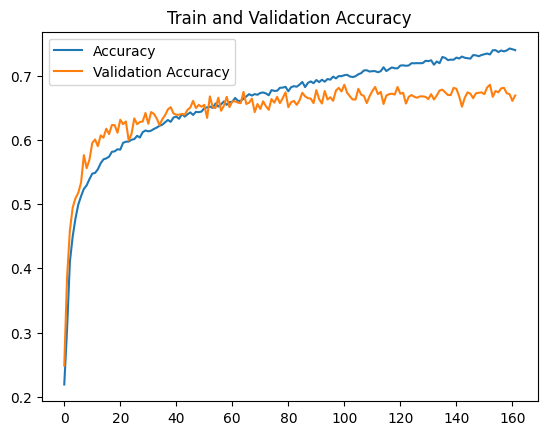

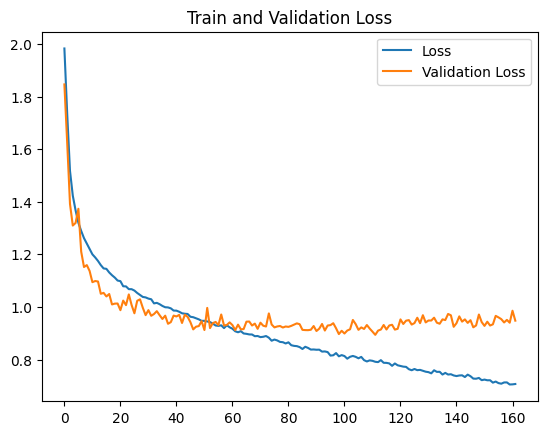

In [ ]:
plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


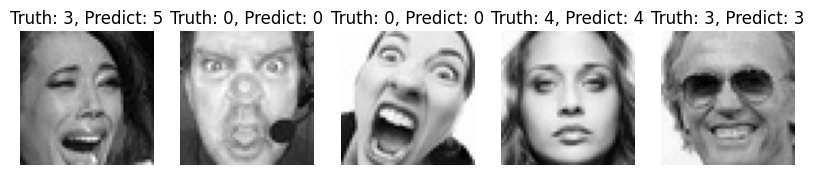

In [ ]:
imgs, labels = next(val_generator)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for i in range(5):
    image = np.expand_dims(imgs[i], axis=0)
    predict = best_model.predict(image)[0].argmax()
    label = np.argmax(labels[i], axis=0)

    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(f'Truth: {label}, Predict: {predict}')
    axes[i].axis('off')

plt.show()


In [ ]:
from google.colab import files

files.download("emotions.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("last.h5")

files.download("last.h5")